# Development of machine learning models to process Electronic Health Records – Explainable Models

### Imputation Comparison

Lok Hang Toby Lee (2431180L)

In [1]:
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sn
from sklearn import metrics


# SET YOUR PATH FOR RESOURCES FILE HERE
resources_path = "C:/Users/USER/OneDrive/GU/Year 4/FYP\MIMIC-III-ML/data/resources"
data_path = "C:/Users/USER/OneDrive/GU/Year 4/FYP/MIMIC-III-ML/data/raw"
results_path = "C:/Users/USER/OneDrive/GU/Year 4/FYP/MIMIC-III-ML/dissertation/Figures/Results"

In [2]:
data = pd.read_csv(data_path+'/mimic_timeseries_data_not_imputed.csv')
data = data.drop(['Unnamed: 0'], axis = 1)
# Filter out subjects with length of stay < 48 hours for the in-hospital mortality task:
y = pd.read_hdf(data_path+'/vitals_hourly_data_preprocessed.h5', 'Y')['los']
indices_to_remove = []
for i, row in y.iteritems():
    if row < 48:
        indices_to_remove.append(i)
        
data = data.reset_index().set_index('icustay_id').drop(indices_to_remove, axis = 0)
y = y.drop(indices_to_remove, axis = 0)

# Extract only the first 48 hours:
data = data[data['hours_in'] < 48].reset_index().drop('index', axis = 1)


In [4]:
# Extract the in-hospital mortality data:
Y = pd.read_hdf(data_path + '/vitals_hourly_data_preprocessed.h5', 'Y')[['in_hospital_mortality', 'los']]
Y = Y.sort_index(axis = 0, level = 'icustay_id')
config = json.load(open(resources_path+'/discretizer_config.json', 'r'))
categorical_var = [key for key, value in  config['is_categorical_channel'].items() if value][1:]

# Remove the icustays that were less than 48 hours:
indices_to_remove = []
for i, row in Y.iterrows():
    if row['los'] < 48:
        indices_to_remove.append(i)
        
Y = Y.drop(indices_to_remove, axis = 0)

data['in_hospital_mortality']=Y['in_hospital_mortality']
y= data.pop('in_hospital_mortality')


# Imputation results Comparison

In [5]:
# Load imputed data
mean_imputed=pd.read_csv(data_path+'/imputed_data/mean_imputed_baseline.csv')
mf_imputed=pd.read_csv(data_path+'/imputed_data/most_frequent_imputed_baseline.csv')
itr_imputed=pd.read_csv(data_path+'/imputed_data/itr_imputed.csv')
knn_imputed=pd.read_csv(data_path+'/imputed_data/knn_imputed.csv')
mice_imputed=pd.read_csv(data_path+'/imputed_data/mice_imputed_final.csv')
midas_imputed=pd.read_csv(data_path+'/imputed_data/midas_imputed.csv')

variable_ranges = pd.read_csv(resources_path+ '/variable_ranges.csv', index_col = None)

imputed_data=[data, mean_imputed,mf_imputed,knn_imputed, mice_imputed, midas_imputed]
imputed_labels=['original','mean imputed', 'most frequent imputed','knn imputed','mice_imputed','midas_imputed']

# Remove outliters
for i in range(len(imputed_data)):
    for column in imputed_data[i].columns:
        if column in variable_ranges['LEVEL2'].values:
            row = variable_ranges[variable_ranges['LEVEL2']==column]

            highs=imputed_data[i].index[imputed_data[i][column]>row['OUTLIER HIGH'].values[0]].tolist()
            lows = imputed_data[i].index[imputed_data[i][column]<row['OUTLIER LOW'].values[0]].tolist()
            imputed_data[i].loc[highs,column]=row['IMPUTE'].values[0]
            imputed_data[i].loc[lows,column]=row['IMPUTE'].values[0]

### Distribution plot

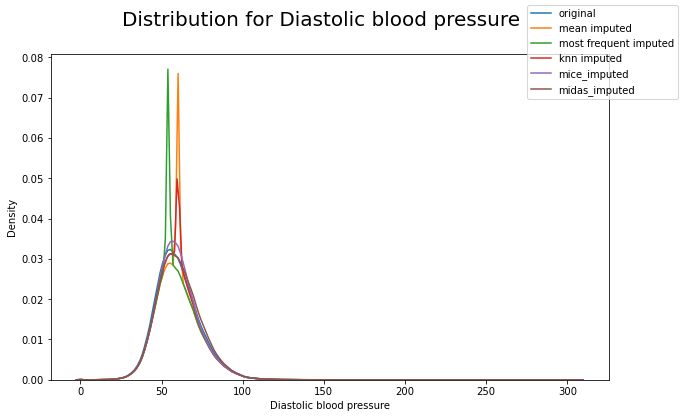

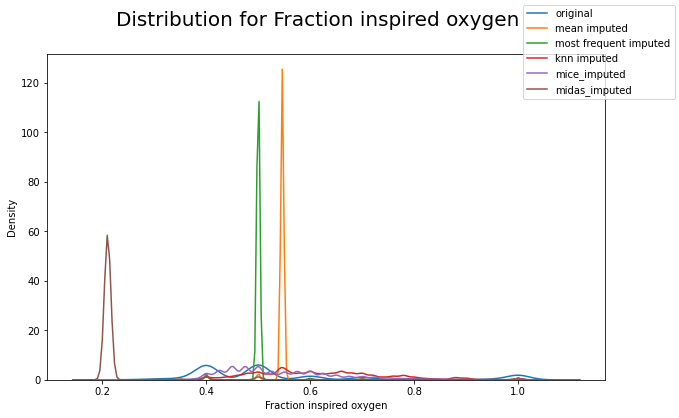

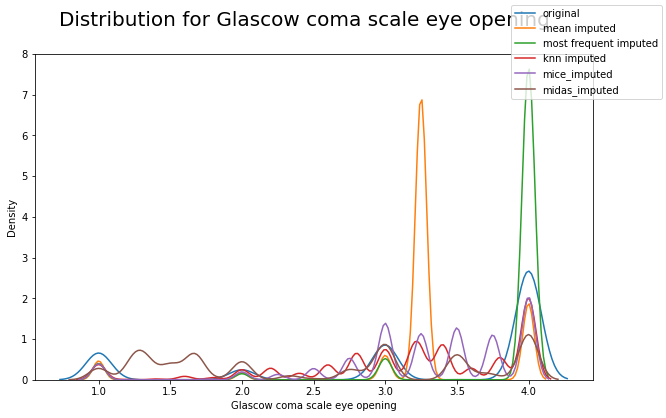

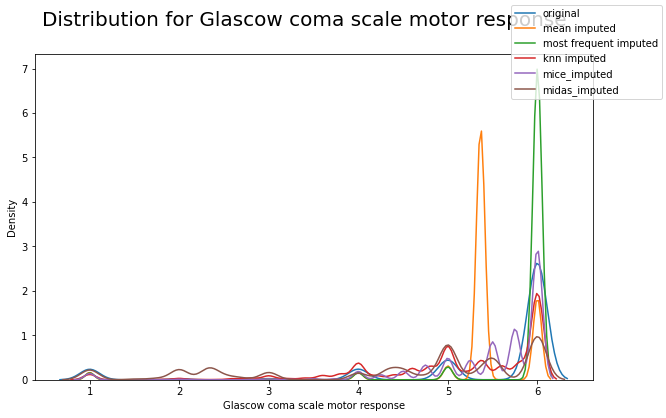

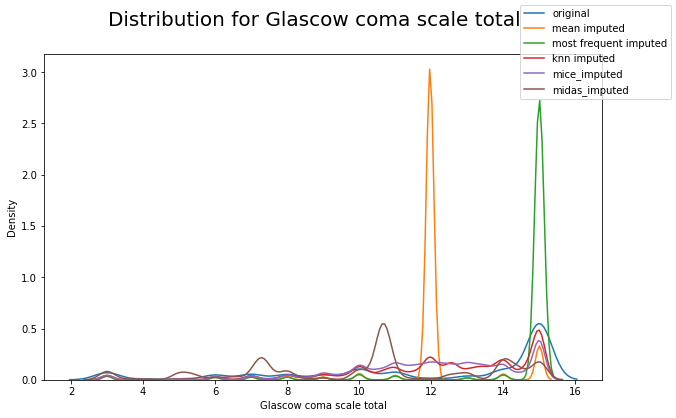

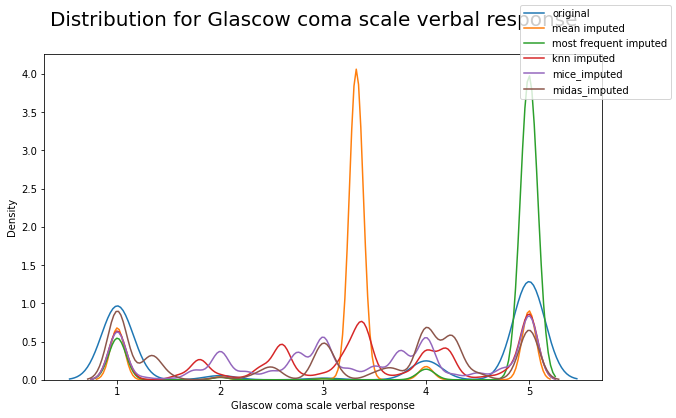

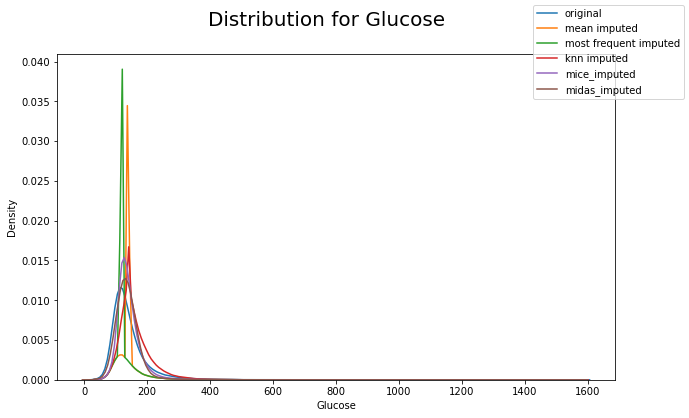

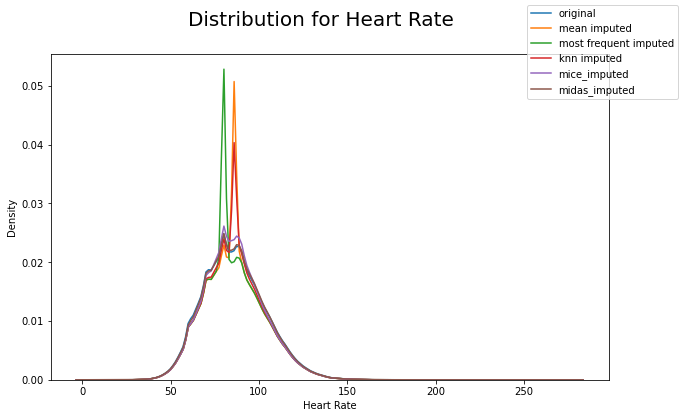

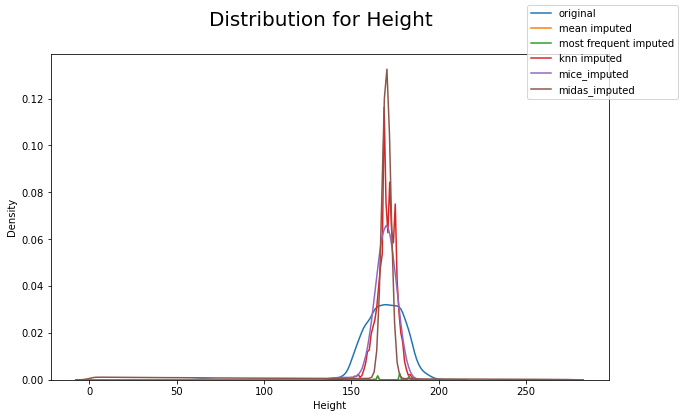

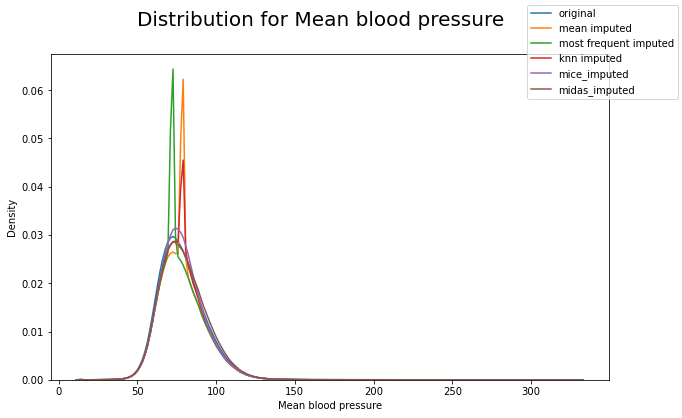

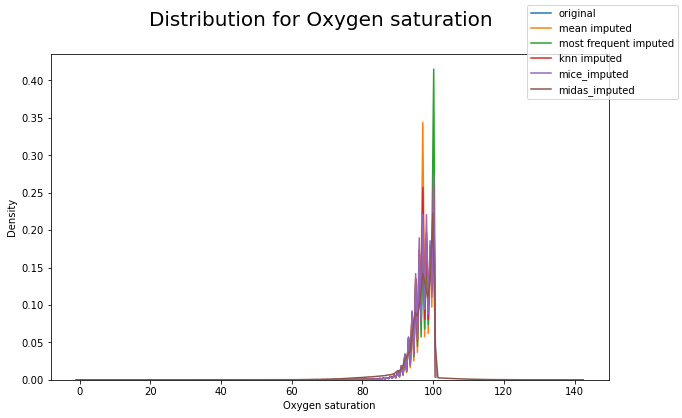

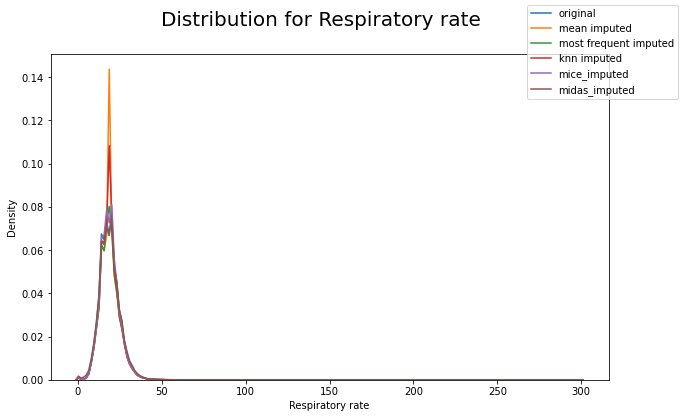

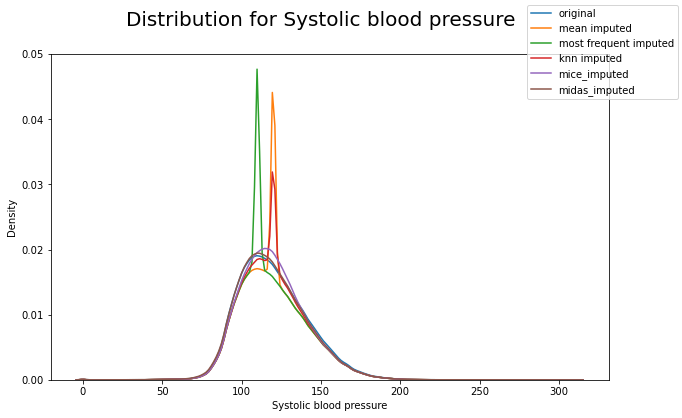

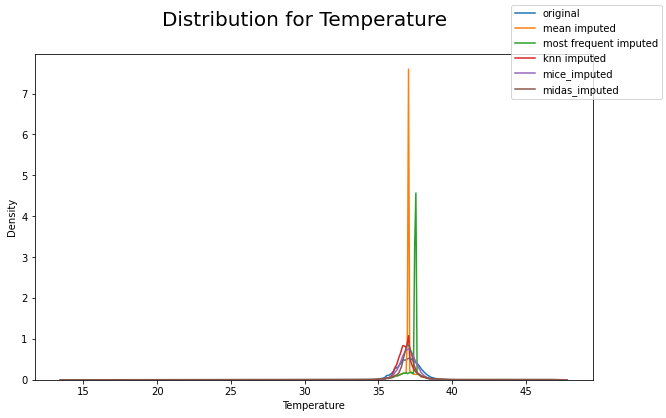

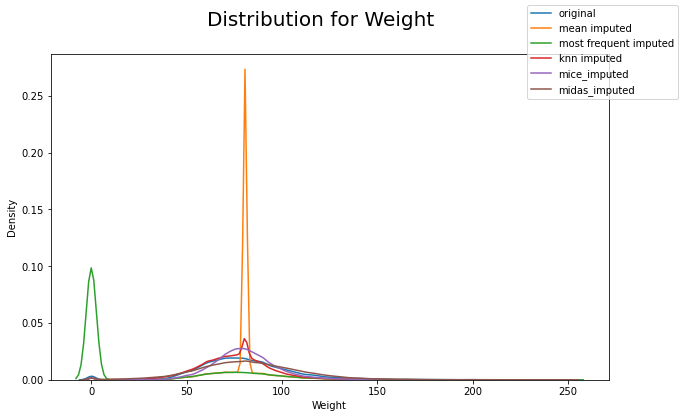

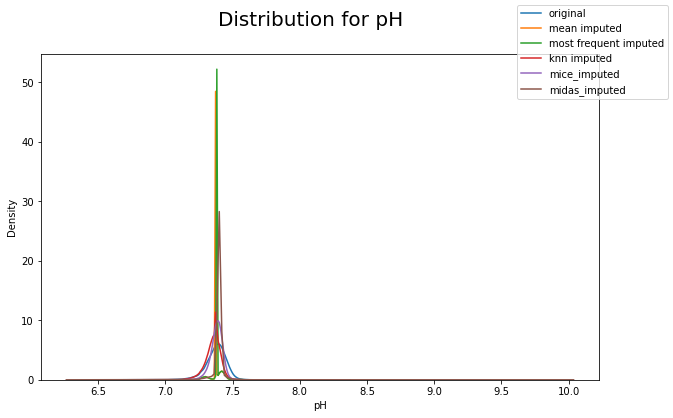

In [40]:
# fig, axes = plt.subplots(4,4, sharex=True, figsize=(40,24))

# count=4
# for i in range(0,4):
#     for x in range(0,4):
#         sn.distplot(data.iloc[:,count], hist=False,  kde_kws=dict(linewidth=5), ax= axes[i,x], axlabel=str(data.columns[count]))
#         sn.distplot(joint_imputed.iloc[:,count], hist=False,  kde_kws=dict(linewidth=3), ax= axes[i,x], axlabel=str(joint_imputed.columns[count]))
#         sn.distplot(mice_imputed_v2.iloc[:,count], hist=False,  kde_kws=dict(linewidth=3), ax= axes[i,x], axlabel=str(mice_imputed_v2.columns[count]))
#         sn.distplot(knn_imputed.iloc[:,count], hist=False,  kde_kws=dict(linewidth=3), ax= axes[i,x], axlabel=str(knn_imputed.columns[count]))
#         sn.distplot(midas_imputed.iloc[:,count], hist=False,  kde_kws=dict(linewidth=3), ax= axes[i,x], axlabel=str(midas_imputed.columns[count]))
#         fig.legend(labels=['original','joint-imputed','mice_imputed_v2','knn_imputed','midas_imputed'])
#         count+=1

# plt.show()


for i in data.columns[4:]:
    fig=plt.figure(figsize=(10,6)) 
    for x in range(len(imputed_data)):
        sn.distplot(imputed_data[x][i], hist=False,  kde_kws=dict(linewidth=1.5))
    fig.legend(labels=imputed_labels)
    fig.suptitle('Distribution for %s'%(i),fontsize=20)
    plt.show()

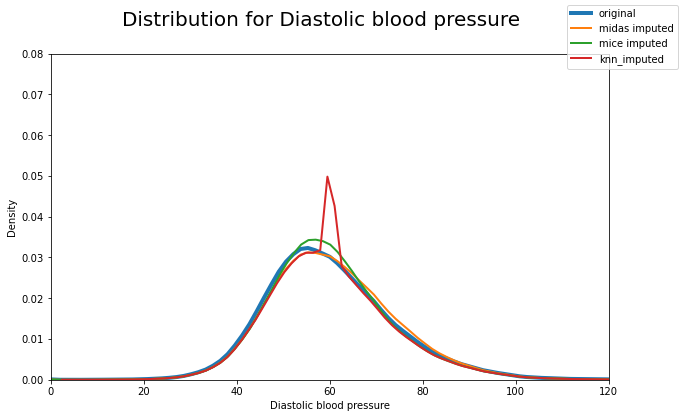

In [39]:
for i in data.columns[4:5]:
    fig=plt.figure(figsize=(10,6))

    sn.distplot(data[i], hist=False,  kde_kws=dict(linewidth=4))
    sn.distplot(midas_imputed[i], hist=False,  kde_kws=dict(linewidth=2))
    sn.distplot(mice_imputed[i], hist=False,  kde_kws=dict(linewidth=2))
    sn.distplot(knn_imputed[i], hist=False,  kde_kws=dict(linewidth=2))

    fig.legend(labels=['original','midas imputed', 'mice imputed', 'knn_imputed'])
    fig.suptitle('Distribution for %s'%(i),fontsize=20)
    plt.axis([0,120,0,0.08])
    plt.show()

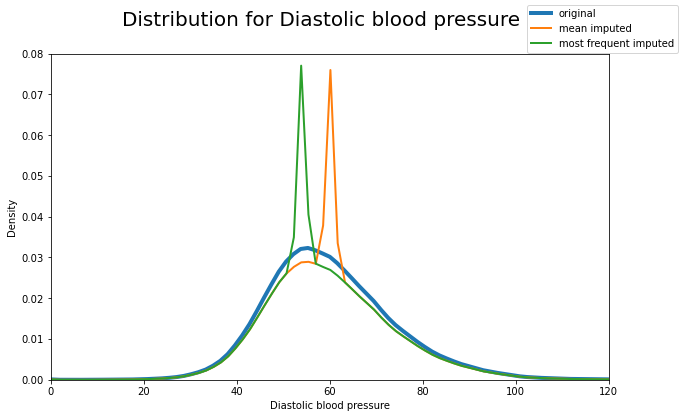

In [29]:
for i in data.columns[4:5]:
    fig=plt.figure(figsize=(10,6))

    sn.distplot(data[i], hist=False,  kde_kws=dict(linewidth=4))
    sn.distplot(mean_imputed[i], hist=False,  kde_kws=dict(linewidth=2))
    sn.distplot(mf_imputed[i], hist=False,  kde_kws=dict(linewidth=2))


    fig.legend(labels=['original','mean imputed','most frequent imputed'])
    fig.suptitle('Distribution for %s'%(i),fontsize=20)
    plt.axis([0,120,0,0.08])
    plt.show()

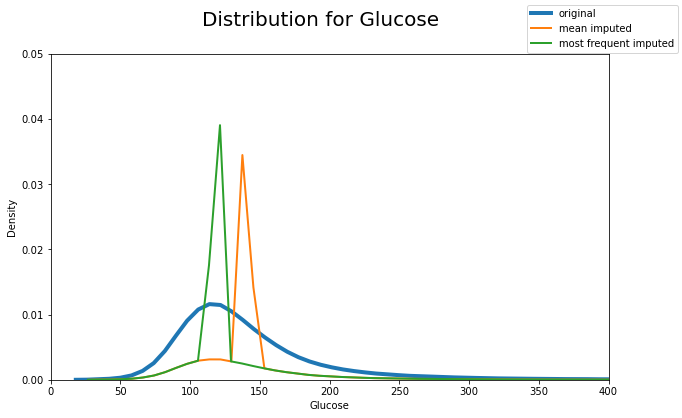

In [44]:
for i in ['Glucose']:
    fig=plt.figure(figsize=(10,6))

    sn.distplot(data[i], hist=False,  kde_kws=dict(linewidth=4))
    sn.distplot(mean_imputed[i], hist=False,  kde_kws=dict(linewidth=2))
    sn.distplot(mf_imputed[i], hist=False,  kde_kws=dict(linewidth=2))


    fig.legend(labels=['original','mean imputed','most frequent imputed'])
    fig.suptitle('Distribution for %s'%(i),fontsize=20)
    plt.axis([0,400,0,0.05])
    plt.show()

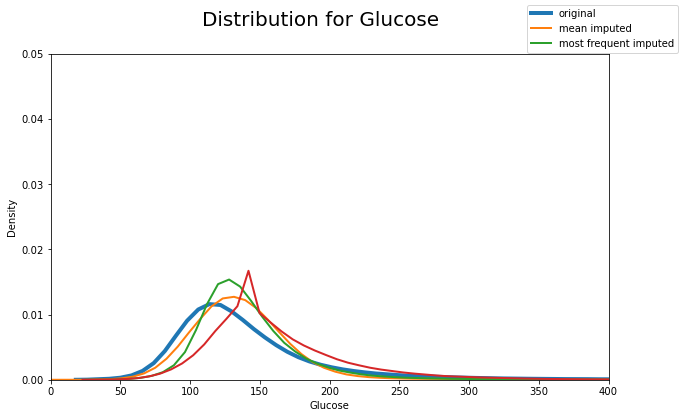

In [46]:
for i in ['Glucose']:
    fig=plt.figure(figsize=(10,6))

    sn.distplot(data[i], hist=False,  kde_kws=dict(linewidth=4))
    sn.distplot(midas_imputed[i], hist=False,  kde_kws=dict(linewidth=2))
    sn.distplot(mice_imputed[i], hist=False,  kde_kws=dict(linewidth=2))
    sn.distplot(knn_imputed[i], hist=False,  kde_kws=dict(linewidth=2))


    fig.legend(labels=['original','mean imputed','most frequent imputed'])
    fig.suptitle('Distribution for %s'%(i),fontsize=20)
    plt.axis([0,400,0,0.05])
    plt.show()

# Classification Performance comparison

### Machine Learning comparison (Logistic regression Baseline)

In [14]:
# ROC Function
from sklearn.model_selection import KFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns

"""
Code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
"""

# Function that plots roc
def plot_roc(classifier,model,X,y,n_splits,c_name):
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

    plt.rc('font', **font)

    cv = KFold(n_splits)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=model,
    )
    ax.legend(loc="lower right")

    plt.savefig('{}/ROC/{}_{}.png'.format(results_path,c_name,model))




In [61]:
# function that plots the confusion matrix
import seaborn as sns
from sklearn.metrics import *
def plot_confusion(y,y_pred,name,c_name):
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

    plt.rc('font', **font)

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('{}'.format(name))
    plt.savefig('{}/Confusion Matrix/{}_{}.png'.format(results_path,c_name,name))


In [9]:
# function for undersample_majority
def undersample_majority(x_train, y_train):
    
    # Separate the positive and negative x/y data:
    pos_features = x_train[y_train == 1]
    neg_features = x_train[y_train == 0]
    pos_labels = y_train[y_train == 1]
    neg_labels = y_train[y_train == 0]
    
    # Count the number of negative data points, and select that many from the positive data points. This means that 
    # positive samples will be 'copied' or repeated and hence occur multiple times in the training data:
    ids = np.arange(len(neg_features))
    choices = np.random.choice(ids, len(pos_features))
    res_neg_features = neg_features[choices]
    res_neg_labels = neg_labels[choices]
    
    # Combine the resamples and negative data points, and shuffle:
    resampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
    resampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)
    order = np.arange(len(resampled_labels))
    np.random.shuffle(order)
    resampled_features = resampled_features[order]
    resampled_labels = resampled_labels[order]
    return resampled_features, resampled_labels

In [8]:
# Minmax standardization of the continuous variables:
def minmax(x):
    mins = x.min()
    maxes = x.max()
    x_std = (x - mins) / (maxes - mins)
    return x_std

def std_time_since_measurement(x):
    idx = pd.IndexSlice
    x = np.where(x==100, 0, x)
    means = x.mean()
    stds = x.std() + 0.0001
    x_std = (x - means)/stds
    return x_std

### Preprocess data

In [10]:
variable_ranges = pd.read_csv(resources_path+ '/variable_ranges.csv', index_col = None)
imputed_data=[mean_imputed,mf_imputed ,knn_imputed, mice_imputed, midas_imputed]
imputed_labels=['Mean imputed', 'Most Frequent imputed','KNN imputed','MICE imputed','MIDAS imputed']


In [11]:
from sklearn.decomposition import PCA
# imputed_data=[mean_imputed,joint_imputed,mice_imputed,mice_imputed_v2,knn_imputed,midas_imputed]
# imputed_labels=['Mean-imputed','joint-imputed','mice_imputed','mice_imputed_v2','knn_imputed','midas_imputed']

for i in range(len(imputed_data)):
    for column in imputed_data[i].columns:

        #Remove outliers
        if column in variable_ranges['LEVEL2'].values:
            row = variable_ranges[variable_ranges['LEVEL2']==column]

            highs=imputed_data[i].index[imputed_data[i][column]>row['OUTLIER HIGH'].values[0]].tolist()
            lows = imputed_data[i].index[imputed_data[i][column]<row['OUTLIER LOW'].values[0]].tolist()
            imputed_data[i].loc[highs,column]=row['IMPUTE'].values[0]
            imputed_data[i].loc[lows,column]=row['IMPUTE'].values[0]
            
        #Min max scaling the values that are not categorical
        if column not in categorical_var:
            imputed_data[i].loc[:, column] = minmax(imputed_data[i].loc[:, column].values)

        # Round Categorial Variables
        if column in categorical_var:
            imputed_data[i].loc[:, column] = np.round(imputed_data[i].loc[:, column].values)



    #One hot encode categorical variables
    #imputed_data[i]= pd.get_dummies(imputed_data[i], columns=categorical_var)

    # PCA
    # pca = PCA(n_components=5)
    # imputed_data[i]=pca.fit_transform(imputed_data[i])


def create_x_matrix(x): # extract the first 48 hours for every icustay.
    zeros = np.zeros((48, x.shape[1]-5))
    x = x.values
    x = x[:48, 5:] # the first four columns are for subject_id, icustay_id, hadm_id and hours_in.
    zeros[0:x.shape[0], :] = x
    return zeros

def create_y_matrix(y):
    y = y['in_hospital_mortality'].to_numpy()
    return y




### Feature importance

In [11]:
from sklearn.inspection import permutation_importance
def show_feature_importance(model,x,y,label):

    
    model.fit(x,y)
    result = permutation_importance(
        model, x, y, n_repeats=10, random_state=42, n_jobs=2
    )

    forest_importances = pd.Series(result.importances_mean, index=np.asarray(data.columns[4:]).tolist())

    # fig, ax = plt.subplots(figsize=(18,12))
    # forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    # ax.set_title("{}".format(label))
    # ax.set_ylabel("Mean accuracy decrease")
    # ax.set_xlabel('Variables')
    # plt.xticks(rotation=45)
    # plt.show()

    return forest_importances

In [14]:
importance_arr

[]

In [14]:
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

importance_arr=[]
for i in range(len(imputed_data)):
    
    start_time = time.time()
    clf_lg = LogisticRegression()
    clf_rf = RandomForestClassifier()
    clf_svc = SVC(gamma='auto')
    
    x=imputed_data[i].iloc[:,4:].values
    y=data.set_index('icustay_id').join(Y,on='icustay_id')['in_hospital_mortality'].values
    print('Evaluating {}...'.format(imputed_labels[i]))
    
    # Evaluate feature importance

    importance_arr.append(show_feature_importance( clf_svc,x,y,imputed_labels[i]))
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Evaluating Mean imputed...


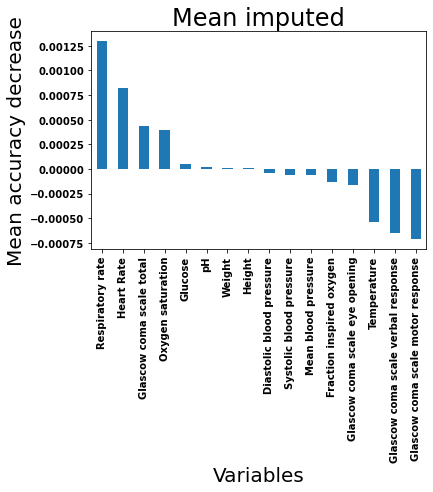

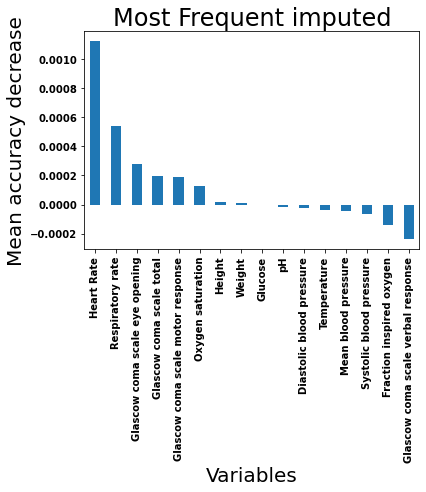

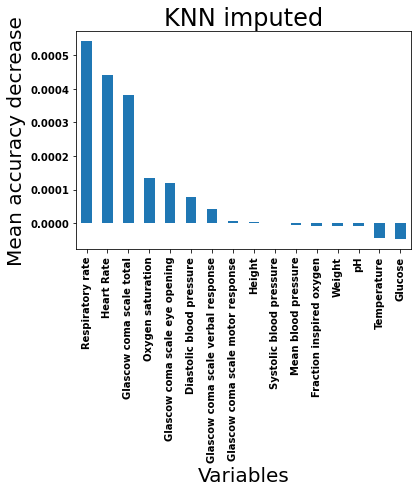

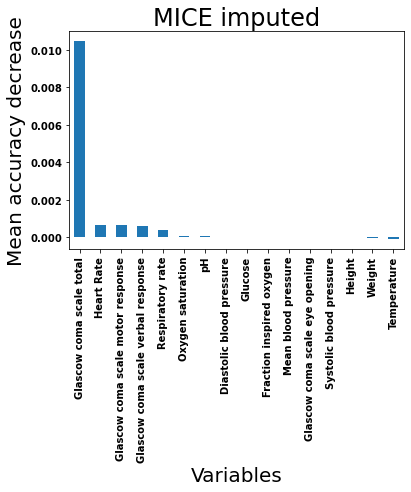

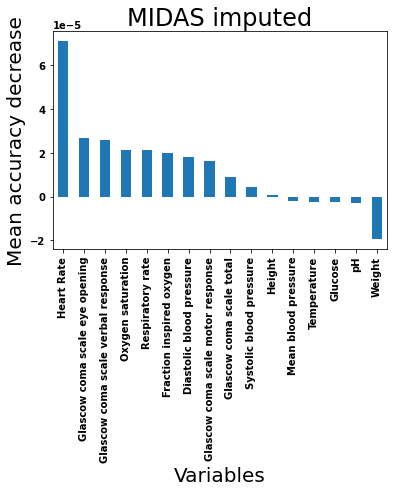

In [93]:
from scipy.stats import pearsonr

for i in range(len(importance_arr)):

    sorted_importance = importance_arr[i].sort_values(ascending=False)

    fig, ax = plt.subplots()
    sorted_importance.plot.bar()
    ax.set_title("{}".format(imputed_labels[i]))
    ax.set_ylabel("Mean accuracy decrease")
    ax.set_xlabel('Variables')
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('{}/Feature importance/{}_{}.png'.format(results_path,'rf',imputed_labels[i]))
    
        # plt.scatter(np.arange(len(importance_arr[i].values)),importance_arr[i].values)
    # corr= pearsonr(np.arange(len(importance_arr[i].values)),importance_arr[i].values)

    # print("Pearsons correlation for {}: {}".format(imputed_labels[i],corr))



### Logistic regression (Train test split)

In [58]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict


imputed_pred=[]
f1_scores=[]

for i in range(len(imputed_data)):

    # x = np.array(list(imputed_data[i].reset_index().groupby('icustay_id').apply(lambda x: x.values[:, 4:])))
    # x = np.reshape(x, (x.shape[0], -1)).astype('float32')
    # y = np.array(list(Y.groupby('icustay_id').apply(lambda i: i['in_hospital_mortality'].to_numpy())))[:, 0].astype('float32')

    x = np.array(list(imputed_data[i].reset_index().groupby('icustay_id').apply(create_x_matrix)))
    x_shape = x.shape
    x = np.reshape(x, (x.shape[0], -1)).astype('float32')
    y = np.array(list(Y.groupby('icustay_id').apply(create_y_matrix)))[:, 0]
    
    clf_rf = RandomForestClassifier()
    clf_lg = LogisticRegression()
    clf_svc = SVC(gamma='auto')

    clf=clf_rf
    u_x,u_y = undersample_majority(x,y)

    #cross_val_score returns the cross validation score given X,y data, the scoring method and the number of folds
    f1_macro = cross_val_score(clf, u_x, u_y, scoring='f1_macro', cv=10)
    f1_scores.append(f1_macro)

    accuracy = cross_val_score(clf, u_x, u_y, scoring='accuracy', cv=10)
    precision = cross_val_score(clf, u_x, u_y, scoring='precision', cv=10)
    recall = cross_val_score(clf, u_x, u_y, scoring='recall', cv=10)



    print("[%s]"%(imputed_labels[i]))
    print(" %0.3f (+/- %0.3f)" % (f1_macro.mean(),f1_macro.std()))
    print("%0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std()))
    print(" %0.3f (+/- %0.3f)" % (precision.mean(),precision.std()))
    print("%0.3f (+/- %0.3f)" % (recall.mean(), recall.std() ))
    print()



    # print("[%s]"%(imputed_labels[i]))
    # print("f1_macro: %0.3f (+/- %0.3f)" % (f1_macro.mean(),f1_macro.std()))
    # print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std()))
    # print("Precision: %0.3f (+/- %0.3f)" % (precision.mean(),precision.std()))
    # print("Recall: %0.3f (+/- %0.3f)" % (recall.mean(), recall.std() ))
    # print()
    
    # cross_val_predict returns the prediction, which is used to create useful plots for comparing performance
    #y_pred= cross_val_predict(clf, u_x, u_y, cv=10)
    #imputed_pred.append(y_pred)

    # Plots the ROC and confusion matrix, this is commented for readibility of code.
    #plot_roc(clf,imputed_labels[i],u_x,u_y,n_splits=5,c_name='lg')
    #plot_confusion(u_y,y_pred,imputed_labels[i],c_name='lg')
    #plot_roc(u_y,y_pred,imputed_labels[i])

[Mean imputed]
f1_macro: 0.785 (+/- 0.015)
Accuracy: 0.780 (+/- 0.012)
Precision: 0.787 (+/- 0.022)
Recall: 0.774 (+/- 0.019)

[Most Frequent imputed]
f1_macro: 0.776 (+/- 0.018)
Accuracy: 0.786 (+/- 0.022)
Precision: 0.786 (+/- 0.028)
Recall: 0.782 (+/- 0.025)

[KNN imputed]
f1_macro: 0.770 (+/- 0.017)
Accuracy: 0.772 (+/- 0.014)
Precision: 0.778 (+/- 0.018)
Recall: 0.753 (+/- 0.027)

[MICE imputed]
f1_macro: 0.778 (+/- 0.013)
Accuracy: 0.771 (+/- 0.012)
Precision: 0.793 (+/- 0.013)
Recall: 0.746 (+/- 0.019)

[MIDAS imputed]
f1_macro: 0.764 (+/- 0.018)
Accuracy: 0.764 (+/- 0.023)
Precision: 0.766 (+/- 0.024)
Recall: 0.772 (+/- 0.023)



### Friedman Test

In [59]:
from scipy import stats

stats.friedmanchisquare(f1_scores[0],f1_scores[1],f1_scores[2],f1_scores[3],f1_scores[4],)

FriedmanchisquareResult(statistic=6.050251256281418, pvalue=0.1954267781955844)

### Nemenyi Test

In [60]:
import scikit_posthocs as sp
import numpy as np

#perform Nemenyi post-hoc test
sp.posthoc_nemenyi_friedman(np.asarray(f1_scores).T)

,0,1,2,3,4
0,1.000000,0.843526,0.241843,0.883657,0.241843
1,0.843526,1.000000,0.803399,0.900000,0.803399
2,0.241843,0.803399,1.000000,0.763265,0.900000
3,0.883657,0.900000,0.763265,1.000000,0.763265
4,0.241843,0.803399,0.900000,0.763265,1.000000


# Deep Learning Classification

In [19]:
# Imports:
import os
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from matplotlib import pyplot as plt
import seaborn as sn
import sys
sys.path.append('C:/Users/USER/Anaconda3/Lib/site-packages')
import plot_metrics as PlotMetrics
import tensorflow as tf
import imp
import warnings
warnings.filterwarnings('ignore')

In [ ]:
imputed_data[0].iloc[:,4:]

,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH
0,0.159609,0.426045,4.0,6.0,15.0,5.0,0.049422,0.425000,0.80797,0.139241,0.970000,0.116667,0.292605,0.679119,0.310000,0.473890
1,0.169381,0.426045,3.0,5.0,12.0,3.0,0.068891,0.421429,0.80797,0.142405,0.960000,0.106667,0.284030,0.801370,0.310000,0.473890
2,0.170467,0.426045,3.0,5.0,12.0,3.0,0.068891,0.414286,0.80797,0.144515,0.950000,0.101111,0.274384,0.756851,0.310000,0.473890
3,0.197068,0.426045,3.0,5.0,12.0,3.0,0.068891,0.400000,0.80797,0.162975,0.935000,0.108333,0.278135,0.726029,0.310000,0.473890
4,0.198697,0.426045,3.0,5.0,12.0,3.0,0.068891,0.385714,0.80797,0.167722,0.915000,0.123333,0.287781,0.667808,0.310000,0.473890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843307,0.267101,0.425458,3.0,5.0,12.0,3.0,0.069426,0.264286,0.80778,0.250000,0.969042,0.063333,0.466238,0.679163,0.322816,0.473926
843308,0.196281,0.425458,3.0,5.0,12.0,3.0,0.069426,0.257143,0.80778,0.204412,0.969042,0.066667,0.386489,0.679163,0.322816,0.473926
843309,0.196281,0.425458,3.0,5.0,12.0,3.0,0.069426,0.292857,0.80778,0.204412,0.969042,0.066667,0.386489,0.679163,0.322816,0.473926
843310,0.211726,0.425458,4.0,6.0,15.0,5.0,0.069426,0.260714,0.80778,0.212025,0.969042,0.066667,0.411576,0.650687,0.322816,0.473926


In [ ]:
imputed_data[0]

,icustay_id,subject_id,hadm_id,hours_in,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH
0,0.0,0.275122,0.635573,0.000000,0.159609,0.426045,4.0,6.0,15.0,5.0,0.049422,0.425000,0.80797,0.139241,0.970000,0.116667,0.292605,0.679119,0.310000,0.473890
1,0.0,0.275122,0.635573,0.021277,0.169381,0.426045,3.0,5.0,12.0,3.0,0.068891,0.421429,0.80797,0.142405,0.960000,0.106667,0.284030,0.801370,0.310000,0.473890
2,0.0,0.275122,0.635573,0.042553,0.170467,0.426045,3.0,5.0,12.0,3.0,0.068891,0.414286,0.80797,0.144515,0.950000,0.101111,0.274384,0.756851,0.310000,0.473890
3,0.0,0.275122,0.635573,0.063830,0.197068,0.426045,3.0,5.0,12.0,3.0,0.068891,0.400000,0.80797,0.162975,0.935000,0.108333,0.278135,0.726029,0.310000,0.473890
4,0.0,0.275122,0.635573,0.085106,0.198697,0.426045,3.0,5.0,12.0,3.0,0.068891,0.385714,0.80797,0.167722,0.915000,0.123333,0.287781,0.667808,0.310000,0.473890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843307,1.0,0.287743,0.349587,0.914894,0.267101,0.425458,3.0,5.0,12.0,3.0,0.069426,0.264286,0.80778,0.250000,0.969042,0.063333,0.466238,0.679163,0.322816,0.473926
843308,1.0,0.287743,0.349587,0.936170,0.196281,0.425458,3.0,5.0,12.0,3.0,0.069426,0.257143,0.80778,0.204412,0.969042,0.066667,0.386489,0.679163,0.322816,0.473926
843309,1.0,0.287743,0.349587,0.957447,0.196281,0.425458,3.0,5.0,12.0,3.0,0.069426,0.292857,0.80778,0.204412,0.969042,0.066667,0.386489,0.679163,0.322816,0.473926
843310,1.0,0.287743,0.349587,0.978723,0.211726,0.425458,4.0,6.0,15.0,5.0,0.069426,0.260714,0.80778,0.212025,0.969042,0.066667,0.411576,0.650687,0.322816,0.473926


In [20]:
x = np.array(list(imputed_data[0].reset_index().groupby('icustay_id').apply(create_x_matrix)))
print(x.shape)
x_shape = x.shape
x = np.reshape(x, (x.shape[0], -1)).astype('float32')
print(x.shape)
y = np.array(list(Y.groupby('icustay_id').apply(create_y_matrix)))[:, 0]

(17569, 48, 16)
(17569, 768)


### Auto-encoder + LSTM Model

In [21]:
# Autoencoder architecture:
class Autoencoder(tf.keras.Model):
    def __init__(self, output_dim = 16*48):
        super(Autoencoder, self).__init__()
        self.output_dim = output_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(units = 256, activation = tf.nn.relu), 
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units = 128, activation = tf.nn.relu),
            tf.keras.layers.Dense(units = 16*48, activation = tf.nn.relu),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(units = 128,  activation = tf.nn.relu),
            tf.keras.layers.Dense(units = 256,  activation = tf.nn.relu),
            tf.keras.layers.Dense(units = output_dim,  activation = tf.nn.relu),  
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [22]:
# Initialize the arrays for the results:
y_true_lstm, predictions_lstm, predictions_logreg = [], [], []
loss_train_ae, loss_val_ae = [], []
loss_train_lstm, loss_val_lstm = [], []
acc_train, acc_val, auc_train, auc_val = [], [], [], []

# Stratified 5-fold cross-validation:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
for train_index, test_index in kf.split(x, y):
    
    # Split in training and test set, and split the training further in training and validation sets:
    x_train, x_val, y_train, y_val = train_test_split(x[train_index], y[train_index], test_size=0.125, random_state=0, 
                                            stratify=y[train_index])
    x_test, y_test = x[test_index], y[test_index]
    
    x_train, y_train = undersample_majority(x_train, y_train)
    
    # Initialize the autoencoder:
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9),
                       loss = tf.keras.losses.MeanSquaredError())
    history_ae = autoencoder.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 20, batch_size = 500, 
                                callbacks = tf.keras.callbacks.ModelCheckpoint(filepath = 'ae_encoding', monitor = 'val_loss',
                                                                            verbose = 1, mode = 'max', 
                                                                            save_weights_only = True, save_best_only = True))    
    
    # Load the best model and get the encodings:
    autoencoder.load_weights('ae_encoding')
    enc_train = autoencoder.encoder(x_train)
    enc_val = autoencoder.encoder(x_val)
    enc_test = autoencoder.encoder(x_test)
    print(enc_train)
    enc_train = np.reshape(enc_train, (-1, x_shape[1], x_shape[2]))
    enc_val = np.reshape(enc_val, (-1, x_shape[1], x_shape[2]))
    enc_test = np.reshape(enc_test, (-1, x_shape[1], x_shape[2]))
    
    # Initialize the LSTM and parameters:
    model_module = imp.load_source(os.path.basename(resources_path+'/lstm.py'), resources_path+'/lstm.py')
    lstm = model_module.Network(dim=16, batch_norm=False, dropout=0.3, depth=2, rec_dropout=0.0, task='ihm', batch_size=8)
    lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9), loss='binary_crossentropy', 
                 loss_weights=None, metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')])
    
    # Training:
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='lstm_ae_encoding', monitor='val_auc', 
                                                      verbose=1, mode='max', save_weights_only=True, save_best_only=True)
    history = lstm.fit(x = enc_train, y = y_train, validation_data = (enc_val, y_val), epochs=80, batch_size=8, 
                       callbacks=[model_checkpoint])

    # Make predictions with the LSTM:
    lstm.load_weights('lstm_ae_encoding')
    pred = lstm.predict(enc_test, batch_size=8, verbose=1)
    predictions_lstm.append(list(pred))
    y_true_lstm.append(list(y_test))
    
    # Baseline: logistic regression
    logreg = LogisticRegression(penalty = 'l2', C = 1, random_state = 0)
    logreg.fit(np.reshape(enc_train, (-1, x_shape[1] * x_shape[2])), y_train)
    pred = logreg.predict_proba(np.reshape(enc_test, (-1, x_shape[1] * x_shape[2])))
    predictions_logreg.append(list(pred))
    
#     # Save the loss and other metrics:
    loss_train_ae.append(history_ae.history['loss'])
    loss_val_ae.append(history_ae.history['val_loss'])
    loss_train_lstm.append(history.history['loss'])
    loss_val_lstm.append(history.history['val_loss'])
    acc_train.append(history.history['accuracy'])
    acc_val.append(history.history['val_accuracy'])
    auc_train.append(history.history['auc'])
    auc_val.append(history.history['val_auc'])

Epoch 1/20
5/6 [========================>.....] - ETA: 0s - loss: 0.4591
Epoch 00001: val_loss improved from -inf to 0.18311, saving model to ae_encoding
6/6 [==============================] - 1s 66ms/step - loss: 0.4545 - val_loss: 0.1831
Epoch 2/20
5/6 [========================>.....] - ETA: 0s - loss: 0.4349
Epoch 00002: val_loss improved from 0.18311 to 0.27811, saving model to ae_encoding
6/6 [==============================] - 0s 42ms/step - loss: 0.4276 - val_loss: 0.2781
Epoch 3/20
4/6 [===================>..........] - ETA: 0s - loss: 0.4011
Epoch 00003: val_loss improved from 0.27811 to 0.44038, saving model to ae_encoding
6/6 [==============================] - 0s 40ms/step - loss: 0.3983 - val_loss: 0.4404
Epoch 4/20
5/6 [========================>.....] - ETA: 0s - loss: 0.3732
Epoch 00004: val_loss improved from 0.44038 to 0.61128, saving model to ae_encoding
6/6 [==============================] - 0s 40ms/step - loss: 0.3712 - val_loss: 0.6113
Epoch 5/20
5/6 [===============

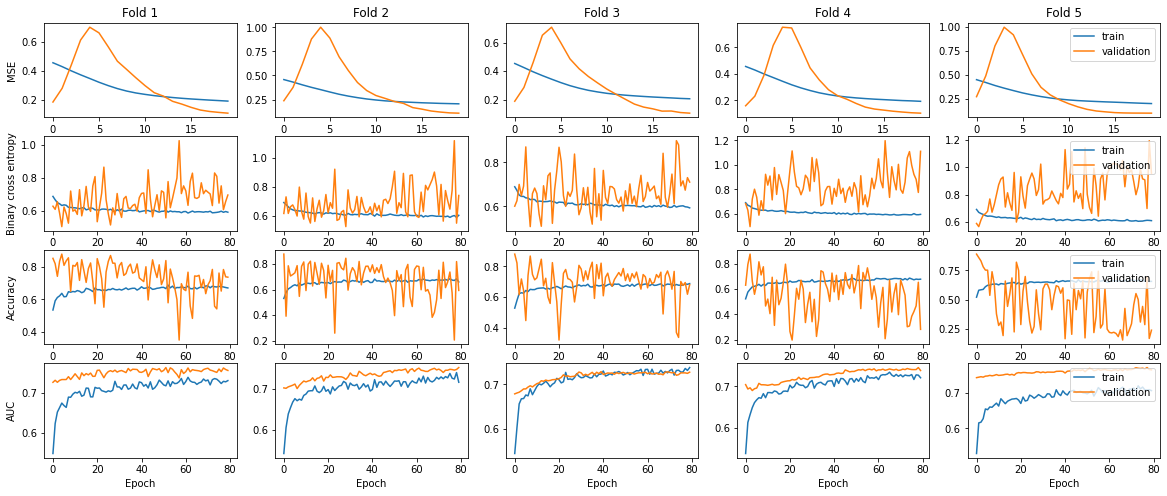

In [23]:
# Look at the loss for every fold:
fig, axs = plt.subplots(4, 5, figsize=(20, 8))
for i in range(5):
    axs[0, i].plot(np.arange(len(loss_train_ae[i])), loss_train_ae[i], label = 'train')
    axs[0, i].plot(np.arange(len(loss_val_ae[i])), loss_val_ae[i], label = 'validation')
    axs[0, i].set_title('Fold ' + str(i + 1))
    
    axs[1, i].plot(np.arange(len(loss_train_lstm[i])), loss_train_lstm[i], label = 'train')
    axs[1, i].plot(np.arange(len(loss_val_lstm[i])), loss_val_lstm[i], label = 'validation')
    
    axs[2, i].plot(np.arange(len(acc_train[i])), acc_train[i], label = 'train')
    axs[2, i].plot(np.arange(len(acc_val[i])), acc_val[i], label = 'validation')
    
    axs[3, i].plot(np.arange(len(auc_train[i])), auc_train[i], label = 'train')
    axs[3, i].plot(np.arange(len(auc_val[i])), auc_val[i], label = 'validation')
    axs[3, i].set_xlabel('Epoch')
    
axs[0, 0].set_ylabel('MSE')
axs[1, 0].set_ylabel('Binary cross entropy')
axs[2, 0].set_ylabel('Accuracy')
axs[3, 0].set_ylabel('AUC')
axs[0, 4].legend(loc = 'upper right')
axs[1, 4].legend(loc = 'upper right')
axs[2, 4].legend(loc = 'upper right')
axs[3, 4].legend(loc = 'upper right')

In [24]:
y_true_lstm_combined = np.concatenate(y_true_lstm)
predictions_lstm_combined = np.concatenate(predictions_lstm)

In [40]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('f1_score:', str(f1_score(y_true_lstm_combined, np.round(predictions_lstm_combined), average='macro')))
print('accuracy_score:', str(accuracy_score(y_true_lstm_combined, np.round(predictions_lstm_combined))))
print('precision_score:', str(precision_score(y_true_lstm_combined, np.round(predictions_lstm_combined))))
print('recall_score:', str(recall_score(y_true_lstm_combined, np.round(predictions_lstm_combined))))


f1_score: 0.5821952572630877
accuracy_score: 0.7161477602595481
precision_score: 0.23915017250771745
recall_score: 0.6229895931882686


Text(123.0, 0.5, 'True label')

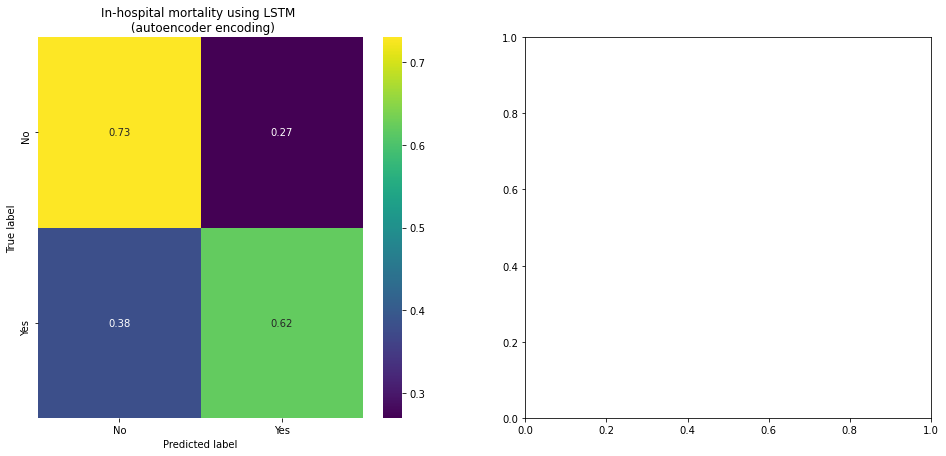

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Confusion matrix for the baseline model:
cm = metrics.confusion_matrix(y_true_lstm_combined, np.round(predictions_lstm_combined), normalize = 'true')
df_cf = pd.DataFrame(np.round(cm, 2), index = ['No', 'Yes'], columns = ['No', 'Yes'])
sn.heatmap(df_cf, annot=True, cmap="viridis", ax = ax[0])
ax[0].set_title('In-hospital mortality using LSTM \n (autoencoder encoding)')
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')

In [33]:
f1_lstm = metrics.f1_score(y_true_lstm_combined, np.round(predictions_lstm_combined))
f1_lstm

0.34562393386694656

Text(0.5, 1.0, 'ROC curves for in-hospital mortality prediction \n (autoencoder encoding)')

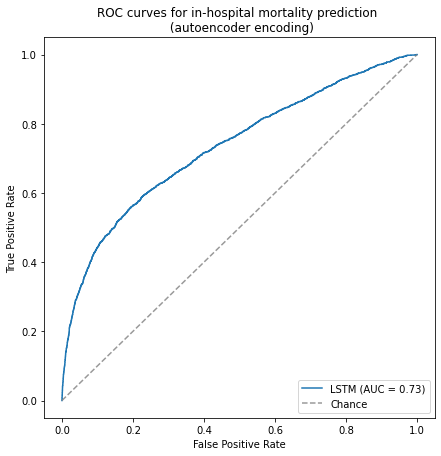

In [29]:
# ROC AUC curve:
roc_auc_lstm = metrics.roc_auc_score(y_true_lstm_combined, predictions_lstm_combined)
fpr_lstm, tpr_lstm, threshold_lstm = metrics.roc_curve(y_true_lstm_combined, predictions_lstm_combined)

fig, ax = plt.subplots(figsize = (7, 7))
ax.plot(fpr_lstm, tpr_lstm, label = 'LSTM (AUC = ' + str(round(roc_auc_lstm, 2)) + ')')
ax.plot([0, 1], [0, 1], linestyle='--', color = 'gray', label = 'Chance', alpha=0.8)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for in-hospital mortality prediction \n (autoencoder encoding)')